In [1]:
#!pip install geopandas

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import re
import pickle
import os
from collections import defaultdict
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words("english")

import gensim

import sys

path_folder = (os.path.abspath(os.path.join((os.path.abspath(os.path.join(os.getcwd(), os.pardir))),os.pardir)))

google_colab = 0
if google_colab == 1:
    from google.colab import drive
    drive.mount('/content/drive/')
    path_folder = "/content/drive/MyDrive/dsprojects/dsproject_grev/"

sys.path.insert(0, path_folder+"/src/features/")
import util

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
class Temp_Ratings_Model_Builder:
    def __init__(self):
        self.review_text_column_name = "review_text"
        self.rating_column_name = "rating"
        binarized_rating_column_name = self.rating_column_name#"binarized_rating"
        self.target_column_name = binarized_rating_column_name    

    def set_up(
        self, reviews_df
    ):
        # ONLY RUN ONCE AT THE START
        # reviews_df contains the y column!
        
        # Non Holistic Operations
        review_text_column = reviews_df[self.review_text_column_name]
        review_text_column = review_text_column.fillna("")
        review_text_column = util.clean_text_column(review_text_column)
        reviews_df[self.review_text_column_name] = review_text_column
        
        pipeline = Pipeline([('count', CountVectorizer(stop_words=stop_words)),
                      ('tfidf', TfidfTransformer())])

        vectorizer = util.Temp_Recipe_Vectorizer_Builder(pipeline)
        self.vectorizer = vectorizer

        tfidf_group_collapser = util.Tfidf_Group_Collapser(
            reviews_df,
            self.target_column_name,
            self.review_text_column_name,
            self.vectorizer
        )
        self.tfidf_group_collapser = tfidf_group_collapser

        self.tfidf_group_collapser.collapse_by_strjoin()

        word2label_df = self.tfidf_group_collapser.build_temp_word2label_df()
        self.word2label_df = word2label_df

        N = 100
        top_n_tfidf_negative_skewed_words_by_contrast_list = (
            word2label_df[word2label_df["arg_label"]==1].sort_values(["stdev"],ascending=False)["word"].head(N).values
        )
        feature_words = top_n_tfidf_negative_skewed_words_by_contrast_list
        self.feature_words = feature_words

        learned_mapping = dict(zip(list(feature_words),list(range(N))))
        learned_count_vectorizer = CountVectorizer(vocabulary=learned_mapping)
        self.learned_count_vectorizer = learned_count_vectorizer
    
    def __call__(self, reviews_df):
        # reviews_df must be train
        self.set_up(reviews_df)
    def get_X(self, reviews_df):
        # can be run many times after set_up
        # reviews_df is for both train and test (or both)

        # Non Holistic Operations
        review_text_column = reviews_df[self.review_text_column_name]
        review_text_column = review_text_column.fillna("")
        review_text_column = util.clean_text_column(review_text_column)
        reviews_df[self.review_text_column_name] = review_text_column
        
        X = self.learned_count_vectorizer.transform(reviews_df[self.review_text_column_name]).tocsc().A
        return X
    def get_y(self, reviews_df):
        # can be run many times after set_up
        # reviews_df is for both train and test (or both)
        # reviews_df contains the y column!

        
        # Non Holistic Operations
        rating_column = reviews_df[self.rating_column_name]
        binarized_rating_column = (rating_column > 4).astype(int)
        target_column = binarized_rating_column
        reviews_df[self.target_column_name] = target_column        
        
        y = 1-(reviews_df[self.target_column_name].astype(int))
        return y
    def data_preparation(self, reviews_df):
        # reviews_df for both train and test (or both)
        # reviews_df contains the y column!
        X = self.get_X(reviews_df)
        y = self.get_y(reviews_df)
        return X, y

In [4]:
stop_words = stopwords.words("english")
negative_words = util.get_negative_words_of_stop_words(stop_words)
for word in negative_words: stop_words.remove(word);

USING_SPARK = 0
DATASET_VERSION = ["FULL", "FILTER"][1]  
DROP_ONE_TIME_APPEARANCES = 1
DROP_SEPARATED_ONE_TIME_APPEARANCES = 0
USING_PICS = 0

reviews_dataset_reader = util.Reviews_Dataset_Reader(
    path_folder, 
    DATASET_VERSION, 
    USING_PICS,
    USING_SPARK,
    DROP_ONE_TIME_APPEARANCES, 
    DROP_SEPARATED_ONE_TIME_APPEARANCES,
)
reviews_df = reviews_dataset_reader.build_reviews_df()

np.random.seed(1)
reviews_df = reviews_df.sample(frac=0.75)
threshold = int(reviews_df.shape[0]*0.75)
train_reviews_df = reviews_df.iloc[:threshold,]
test_reviews_df = reviews_df.iloc[threshold:,]
(train_reviews_df["rating"]>4).mean(), (test_reviews_df["rating"]>4).mean()

1it [00:17, 17.67s/it]
100%|████████████████████████████████████████████████████████████████████████| 11015/11015 [00:00<00:00, 348799.66it/s]


(0.6277490244738689, 0.6285448400842435)

In [5]:
temp_ratings_model_builder = Temp_Ratings_Model_Builder()
temp_ratings_model_builder(train_reviews_df)

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████████████████████████████████████████████████████████████████████| 1431/1431 [00:00<00:00, 416606.44it/s]


In [6]:
X_train, y_train = temp_ratings_model_builder.data_preparation(train_reviews_df)
y_train.mean()

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.372250975526131

In [7]:
X_test, y_test = temp_ratings_model_builder.data_preparation(test_reviews_df)
y_test.mean()

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.37145515991575645

In [8]:
model = LogisticRegression(class_weight="balanced",max_iter=300)
model.fit(X_train, y_train)
predictions = model.predict(X_train)
acc = np.mean(predictions==y_train)
print(acc)

0.6619373377524531


In [10]:
###########

def fit_model_subset(X_train, y_train):
    model = LogisticRegression(class_weight="balanced",max_iter=300)
    model.fit(X_train, y_train)
    predictions = model.predict(X_train)
    acc = np.mean(predictions==y_train)
    print(acc)
    return model

def undersampling_fitting(
    X_train, 
    y_train,
    num_subset_model_fittings = 10
    ):
    good_reviews_indices = np.where(y_train == 0)[0]
    bad_reviews_indices = np.where(y_train == 1)[0]
    #print(len(bad_reviews_indices)/(len(bad_reviews_indices) + len(good_reviews_indices)))
    subset_size = bad_reviews_indices.shape[0] # len(good_reviews_indices) // num_subset_model_fittings
    subset_models = []

    for i in (range(num_subset_model_fittings)):
        good_reviews_subset_indices = np.random.choice(good_reviews_indices,size=subset_size)

        good_reviews_subset = X_train[good_reviews_subset_indices,:]
        bad_reviews = X_train[bad_reviews_indices,:]

        X_train_subset = np.vstack([good_reviews_subset, bad_reviews])
        y_train_subset = np.array(
            [0 for _ in range(good_reviews_subset.shape[0])] + \
            [1 for _ in range(bad_reviews.shape[0])]
        )

        shuffler_indices = np.arange((good_reviews_subset.shape[0]) + (bad_reviews.shape[0]))
        np.random.shuffle(shuffler_indices)

        X_train_subset_shuffled = X_train_subset[shuffler_indices]
        y_train_subset_shuffled = y_train_subset[shuffler_indices]
        
        subset_model = fit_model_subset(X_train_subset_shuffled, y_train_subset_shuffled)
        subset_models.append(subset_model)

    return subset_models

##############
subset_models = undersampling_fitting(X_train, y_train, 10)
model_coefs = np.array([model.coef_ for model in subset_models])
model_intercepts = np.array([model.intercept_ for model in subset_models])
model_coefs = np.squeeze(model_coefs,1)
model_intercepts = np.squeeze(model_intercepts,1)
model_coefs_std = np.std(model_coefs, axis=1, keepdims=1,ddof=0)
model_coefs_ = model_coefs / model_coefs_std
model_coefs_avg = np.mean(model_coefs_,axis=0)
model_intercepts_ = model_intercepts #/ np.squeeze(model_coefs_std,1)
model_intercepts_avg = np.mean(model_intercepts_)
########################
sigmoid = lambda x: 1/(1+(np.exp(-x)))

predictions_prob_undersampled = sigmoid((X_test @ np.expand_dims(model_coefs_avg,1)+model_intercepts_avg))

predictions = (predictions_prob_undersampled > 0.5).astype(int)

predictions = np.squeeze(predictions,1)

y_test.shape, predictions.shape

acc = np.mean(predictions==y_test)
print(acc)

0.5993201754385965
0.5960526315789474
0.596798245614035
0.5977412280701755
0.5969298245614035
0.5967543859649123
0.596140350877193
0.59875
0.5974561403508772
0.5973684210526315
0.636675319586619


In [12]:
confusion_matrix_array = confusion_matrix(y_test, predictions, normalize="true")
print(confusion_matrix_array)
#f, ax = plt.subplots(figsize=(9, 9))
#heatmap = sns.heatmap(confusion_matrix_array, annot=True)

[[0.77440972 0.22559028]
 [0.59638713 0.40361287]]


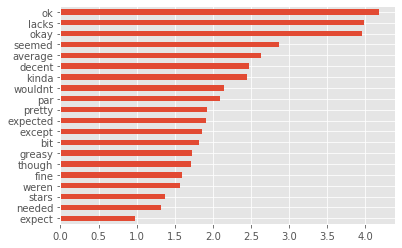

In [13]:
pd.Series(index=temp_ratings_model_builder.feature_words, 
          data=model_coefs_avg).sort_values(ascending=False).head(20)[::-1].plot.barh()#(type="barh")